# Importy

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from mpl_toolkits.basemap import Basemap
from windrose import WindroseAxes

def drawdemp(random_sample, sub=None, title=None,  xlim_min=None, xlim_max=None, line_style=""):
    """Draws CDF for the given random_sample."""
    xs = np.array(random_sample, dtype=np.float)
    xs.sort()
    step = (xs[-1] - xs[0]) / xs.size
    xs = np.insert(xs, 0, xs[0] - step)
    xs = np.insert(xs, xs.size, xs[-1] + step)
    ys = np.linspace(0, 1, xs.size - 1)

    fig, ax = plt.subplots()
    ax.hlines(y=ys, xmin=xs[:-1], xmax=xs[1:])
    ax.vlines(x=xs[1:-1], ymin=ys[:-1], ymax=ys[1:], linestyle='dashed')
    ax.set_xlim(min(xs), max(xs))
    plt.xlabel("x")
    plt.ylabel("F(x)")
    if xlim_min:
        ax.set_xlim(xlim_min, max(xs))
    if xlim_max:
        ax.set_xlim(min(xs), xlim_max)
    if xlim_min and xlim_max:
        ax.set_xlim(xlim_min, xlim_max)
    if sub:
        plt.plot(xs, [sub(i) for i in xs], line_style)
    if title:
        plt.title(title)
    plt.show()


# Symulator elektrowni wiatrowej

Będziemy analizować dane o wietrze z Dolnego Śląska z lat 2018-2020. 
Kierunki przyjmują wartości od $0^{\circ}$ do $360^{\circ}$, gdzie kąt $0^{\circ}$ oznacza północ.
Z kolei prędkość wiatru jest wyrażona w m/s.


In [5]:
wind_data = pd.read_csv("data_wind.csv", index_col=0)
wd = wind_data['dir']
ws = wind_data['speed']
wind_data

,time,lat,lon,dir,speed
37,1/1/2018 0:00,52.0,14.0,42.769585,6.416429
38,1/1/2018 0:00,52.0,14.5,41.314840,5.645424
39,1/1/2018 0:00,52.0,15.0,34.477335,4.658505
40,1/1/2018 0:00,52.0,15.5,33.692548,5.024167
41,1/1/2018 0:00,52.0,16.0,35.428441,5.584211
...,...,...,...,...,...
55840,1/1/2020 0:00,50.0,16.0,111.680299,4.236789
65840,1/1/2020 0:00,50.0,16.5,120.152730,1.881690
75840,1/1/2020 0:00,50.0,17.0,131.894351,1.460385
85840,1/1/2020 0:00,50.0,17.5,90.548203,1.587150


**Histogram kołowy**

Text(0.5, 1.0, 'Histogram wiatrów na Dolnym Śląsku')

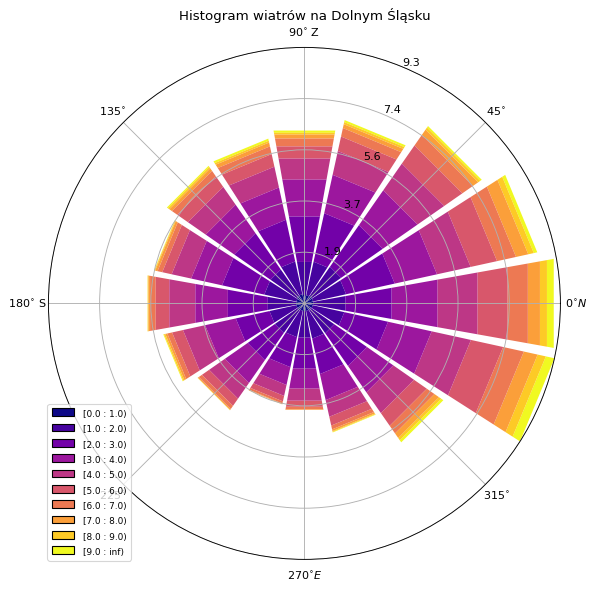

In [7]:
nsector = 16 # kierunki
nbin = 10 # prędkości
ax = WindroseAxes.from_ax()
ax.bar(wd, ws, normed=True, opening=0.9, nsector=nsector, bins=np.arange(0, nbin), cmap=plt.cm.plasma)
ax.set_legend()
ax.set_xticklabels(['$0^{\circ} N$', '$45^{\circ}$', '$90^{\circ}$ Z', '$135^{\circ}$', '$180^{\circ}$ S    ',\
'$225^{\circ}$','$270^{\circ} E$', '$315^{\circ}$'])
ax.set_title('Histogram wiatrów na Dolnym Śląsku')

**Generatory**

Obliczmy częstotliwości prędkości i narysujmy odpowiedni histrogram. 

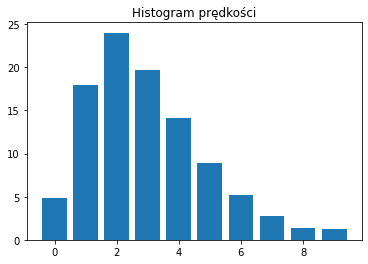

In [8]:
table = ax._info['table']
ws_freq = np.sum(table, axis=1)
plt.bar(np.arange(nbin), ws_freq, align='center', )
plt.title('Histogram prędkości')
plt.show()

Można zauważyć, że histogram prędkości przypomina rozkład Weibulla. Parametr kształtu przyjmiemy równy 2, a za parametr skali weźmiemy średnią prędkość wiatru.

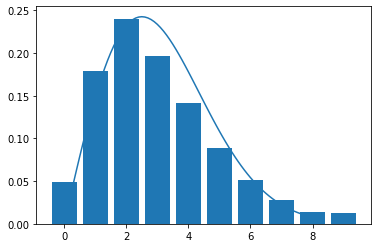

In [9]:
A = ws.mean()
k = 2
ws_freq2=np.array(ws_freq)/100

def weibull_pdf(x, l, k):
    if x >= 0:
        return k/l * (x/l)**(k-1)*np.exp(-(x/l)**k)
    return 0
    
xs = np.arange(0,8,0.1)
ys = [weibull_pdf(x,A,k) for x in xs]

plt.bar(np.arange(nbin), ws_freq2, align='center')
plt.plot(xs,ys)

Dopasowanie nie jest idealne, ale możemy przyjąć, że rzeczywiście prędkość wiatru ma rozkład $W(A, 2)$, gdzie $A$ to średnia prędkość.

Aby napisać generator zmiennych losowych, które będą odpowiadały rozkładowi prędkosci wiatrów skorzystamy z metody odwracania dystrybuanty.

Dystrybuanta rozkładu $W(A,k)$ wyraża się wzorem: 
$$F(x) = 1 - e^{-(x/A)^k}, x\ge 0.$$
Zatem dystrybuanta odwrotna jest równa $$F^{-1}(x) = A(-\ln(1-y))^{\frac{1}{k}}.$$

<ipython-input-4-4133baba3490>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xs = np.array(random_sample, dtype=np.float)


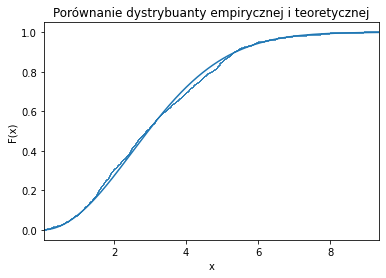

In [10]:
def gen_wind_speed_distr(n=1):
    A = ws.mean()
    U = np.random.uniform(size=n)
    return A*np.sqrt(-np.log(U))

X = gen_wind_speed_distr(1000)
drawdemp(X, sub= lambda x:stats.weibull_min.cdf(x, c=2, scale=A), title='Porównanie dystrybuanty empirycznej i teoretycznej')

Wykresy pokrywają się, zatem generator działa poprawnie.

Na potrzeby naszego prostego modelu nierealistycznie zakładamy, że prędkość wiatru jest niezależna od kierunku, jak również pory roku/dnia itp. To samo będziemy zakładać dla kierunków wiatrów.


Do generowania zmiennych losowych odpowiadających kierunkom wiatrów wykorzystamy metodę akceptacji-odrzucenia dla rozkładów dyskretnych. Nasz rozkład kierunków przyjmuje 262845 wartości, każde z tym samym prawdopodobieństwem. W tym wypadku metoda akceptacji-odrzucenia sprowadza się do losowania wartości z tej próbki.

In [18]:
def gen_wind_dir_distr(n=1):
    return np.random.choice(wd, n)
    
d = gen_wind_dir_distr(10)
print(d)

[284.9621045  355.3153543  103.5628577    5.17022908 300.4027854
 182.0219362  350.6115433  230.5038137  318.6047824   56.08317169]


**Statystyki**

Do obliczenia średniej kołowej wykorzystamy wzory: 
$$\theta = x \mod 2\pi; $$
$$\overline{Z} = \frac{1}{N}\sum_{k=1}^{N}{e^{i\theta_k}}.$$

In [19]:
def circle_mean(data):
    theta = np.array(data) % 2*np.pi
    return np.mean(np.exp(1j * theta))

circle_mean(ws)

(-0.0026774347873279106+0.0002810755196357839j)

Z kolei wariancje obliczymy ze wzoru: $$D^2Z =1 - |\overline{Z}|$$

In [20]:
def circle_var(data):
    return 1 - np.abs(circle_mean(data))

circle_var(ws)

0.997307852067933

Trajektorie cząstki

Poniższa funkcja generuje n wiatrów (w odstępach czasu dt) i zwraca kolejne położenia nieważkiej cząstki.

In [21]:
def gen_positions(dt= 10, n=100, start=(0,0)):
    R_earth = 6.4*10**6
    lons = np.zeros(n) # szerokość --
    lats = np.zeros(n) # długość |
    lons[0] = start[0]
    lats[0] = start[1]
    for i in range(1,n):
        alpha = gen_wind_dir_distr()
        r = gen_wind_speed_distr()
        y = r*dt*np.sin(alpha)
        x = r*dt*np.cos(alpha)
        a = 180*x/(np.pi*R_earth)
        b = 180*y/(np.pi*R_earth)
        lons[i] = lons[i-1] + a
        lats[i] = lats[i-1] + b

    return lons, lats

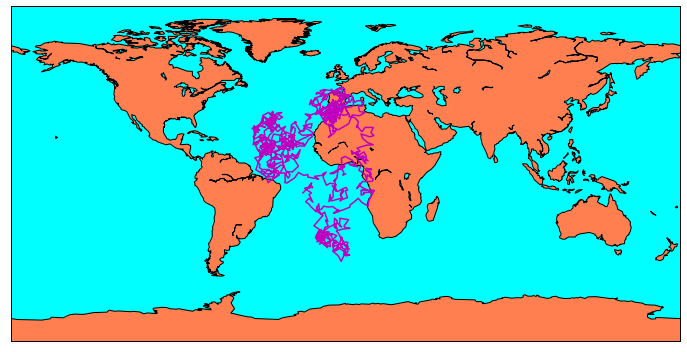

In [23]:
plt.figure(figsize=(12,8))
map = Basemap(projection='cyl')
# map = Basemap(projection='ortho', lat_0=0, lon_0=0)
map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='coral',lake_color='aqua')
map.drawcoastlines()

lons, lats = gen_positions(dt=60*60*24, n=1000)
x, y = map(lons, lats)
map.plot(x, y, marker=None,color='m')
plt.show()

Na powyższym rysunku widzimy błądzenie cząstki na mapie przez 1000 dni. Położenie cząstki jest aktualizowane co dobę.


**Moc generowana przez wiatrak**

W naszym modelu zakładamy, że wiatrak ustawiony jest optymalnie, czyli w kierunku północnym. Jeśli wiatr wieje z przodu na wiatrak albo z tyłu to efektywność wiatraka wynosi $100\%$. Jeśli wiatr wieje z boku to wiatrak się nie kręci. Zależność efektywności od kierunku wiatru obrazuje poniższy wykres.

Text(0, 0.5, 'efektywność')

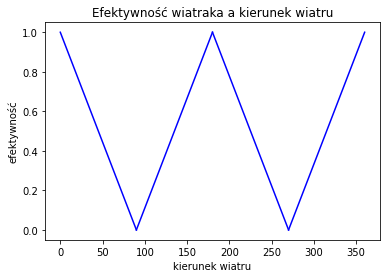

In [24]:
x1 = np.linspace(0,90,100)
plt.plot(x1, 1- x1/90, 'b')
x2 = np.linspace(90,180,100)
plt.plot(x2, x2/90 - 1, 'b')
x3 = np.linspace(180,270,100)
plt.plot(x3, 3- x3/90, 'b')
x4 = np.linspace(270,360,100)
plt.plot(x4, x4/90 - 3, 'b')
plt.title('Efektywność wiatraka a kierunek wiatru')
plt.xlabel('kierunek wiatru')
plt.ylabel('efektywność')

Skoro dla optymalnego położenia wiatraka i prędkości wiatru $3$ $[m/s]$ moc dostarczana przez wiatrak wynosi $17.3$ $[kW]$, to dla prędkości $v$ moc wynosi $P = \frac{17.3}{3}v $ $[kW]$. Biorąc pod uwagę zmienną efektywność wiatraka w zależności od kierunku wiatru ostatecznie otrzymujemy:
$$P =\frac{17.3}{3}v f ,$$ gdzie $f \in[0,1]$ to właśnie efektywność.

In [25]:
def wind_turbine(n, dt=60): # dt [s] 
    """Return list (size n) of powers [kW] produced by wind turbine by dt[s]"""
    a = 17.3/3
    P = np.zeros(n)
    for i in range(n):
        w_dir = gen_wind_dir_distr()
        w_speed = gen_wind_speed_distr()
        conditions = [1 -  w_dir/90, w_dir/90 - 1, 3 - w_dir/90, w_dir/90 - 3]
        f = conditions[int(w_dir//90)]
        P[i] = a*w_speed*f
    return P 

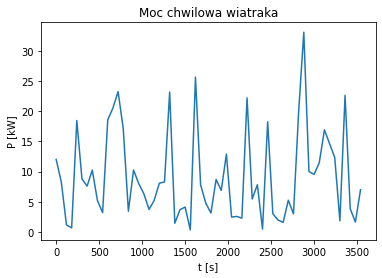

In [26]:
tur = wind_turbine(60)
plt.plot(np.arange(0, 60*60, 60), tur)
plt.title('Moc chwilowa wiatraka')
plt.xlabel('t [s]')
plt.ylabel('P [kW]')
plt.show()

Powyższy wykres przedstawia moc chwilawą wiatraka w ciągu godziny, z wiatrem zmieniającym się co minutę.

**Energia wytwarzana przez wiatrak**

Praca wykonana przez wiatrak to pole pod wykresem $P(t).$ Będziemy ją przybliżać prostokątami o bokach $P(t_i)$ i $dt = t_{i+1} - t_{i}$.

In [28]:
def monte_carlo_work(n, dt=60): # dt[s]
    """Calculates work [kJ] done by wind turbine during [0, n*dt]."""
    return  np.sum(wind_turbine(n, dt))*dt

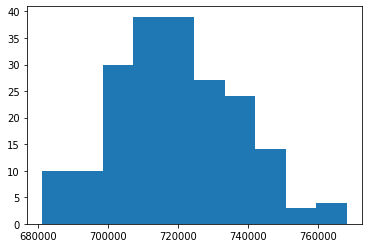

In [31]:
data = np.zeros(200) #dosyć długo się wywołuje ok. 3 min
for i in range(200):
    data[i] = monte_carlo_work(60*24, 60)
plt.hist(data)
plt.show()

Powyższy wykres przedstawia histogram pracy $W [kJ]$ wykonanej przez wiatrak w ciągu doby. Poniżej znajduje się kilka przydatnych statystyk.

In [32]:
print("Średnia:", np.mean(data))
print("Wariancja:", np.var(data))
print("Odchylenie standardowe:", np.std(data))
print("Dolny kwartyl:", np.quantile(data, 0.25))
print("Górny krawrtyl:", np.quantile(data, 0.75))

Średnia: 719083.395693641
Wariancja: 295361396.820828
Odchylenie standardowe: 17186.081485342376
Dolny kwartyl: 707293.8376865409
Górny krawrtyl: 730466.3385468225


Nasz wiatrak wytwarza średnio $ 719000 [kJ]$ energi w ciągu doby. W skali roku daje to aż ok. $262 000 000 [kJ].$

**Symulacja działki z wiatrakiem**

Na koniec sprónujemy zasamulować samowystarczalną elektrycznie działkę z wiatrakiem i akumulatorem. Zapotrzebowanie na energię elektryczną zmienia się w ciągu doby. W naszym modelu procentowe zurzycie energi w ciągu dnia jest zobrazowane na poniższym wykresie.

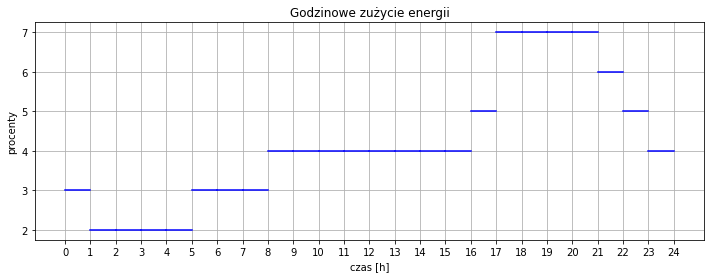

In [33]:
model_asumptions = (0.01)*np.array([3, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 7, 7, 7, 7, 6, 5, 4])

t = 0
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 1, 1)
for i in model_asumptions:
    plt.plot(np.linspace(t, t+1, 10), [i*100]*10, 'b')
    t += 1

major_ticks = np.arange(0, 25, 1)
ax.set_xticks(major_ticks)
plt.title("Godzinowe zużycie energii")
plt.xlabel('czas [h]')
plt.ylabel('procenty')
plt.grid()
plt.show()

Trzyosobowa rodzina zużywa ok. $2100 [kWh] = 7560 000[kJ]$ energi w ciągu roku. Poprzednio obliczyliśmy, że nasz wiatrak wytwarza średnio $262000000[kJ]$ energii rocznie. Zatem trzyosobowa rodzina wykorzystywałaby tylko ok. $3\%$, stąd przypuszczamy iż jeden wiatrak powienien być w stanie zapewnieć nieprzerwane dostawy mocy.

Zasymulujemy samowystarczalną działkę z jednym wiatrakiem. Będziemy generować nowy wiatr co godzinę, obliczać wytworzoną przez niego w tym czasie energię, a następnie odejmować energię wykorzystaną przez gospodarstwo domowe (uwzględniając zmienne zapotrzebowanie w ciągu doby). Nadmiar energii magazynujemy w akumulatorze o nieskończonej pojemności.
Jeśli zapotrzebowanie na energię będzie większe niż to zmagazynowane, przerywamy symulacje.

In [34]:
def simulate_turbines(ele_usage_per_day, n=365*24):
    """Returns list od energies stored in acumulator, list of differences 
    between generated and used energy and max intake from batery."""
    data_power = wind_turbine(n, dt=3600)
    acumulator = 0
    dif_state = np.zeros(n)
    ac_state = np.zeros(n)
    for i in range(n):
        dif = data_power[i]*3600 - ele_usage_per_day * model_asumptions[i % 24] # W = Pt
        acumulator += dif
        ac_state[i] = acumulator
        dif_state[i] = dif
        if acumulator < 0:
            print("Symulacja została przerwana z powodu przerwy w dostawie prądu :(")
            return ac_state, dif_state
    return ac_state, dif_state

Niech nasza symulacja "trwa" 30 dni.

In [35]:
ele_usage = 2100*60*60 #[kJ per year]
ele_usage_per_day = ele_usage/365

ac_state, dif_state= simulate_turbines(ele_usage_per_day, n=30*24)

Symulacja nie została przerwana zatem jeden wiatrak jest w stanie zagwarantować nieprzerane dostawy mocy dla trzyosobowej rodziny. Przyjrzyjmy się ilości energi zgromadzonej na akumulatorze.

Text(0, 0.5, 'energia [kJ]')

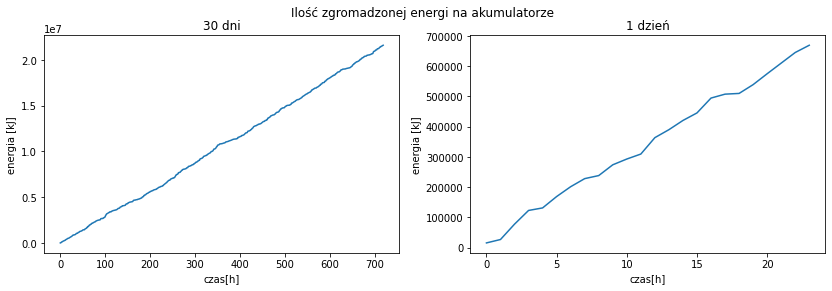

In [36]:
fig, axs = plt.subplots(1,2, figsize=(14,4))
plt.suptitle('Ilość zgromadzonej energi na akumulatorze')
axs[0].plot(ac_state)
axs[0].set_title('30 dni')
axs[0].set_xlabel('czas[h]')
axs[0].set_ylabel('energia [kJ]')
axs[1].plot(ac_state[:24])
axs[1].set_title('1 dzień')
axs[1].set_xlabel('czas[h]')
axs[1].set_ylabel('energia [kJ]')

Ilość niewykorzystanej energii rośnie bardzo szybko. Na pierwszy rzut oka mogło by się wydawać, że nidgy nie pobieramy mocy z akumulatora. Przyjrzyjmy się wykresowi zmiany kJ w akumulatorze.

Text(0, 0.5, 'energia [kJ]')

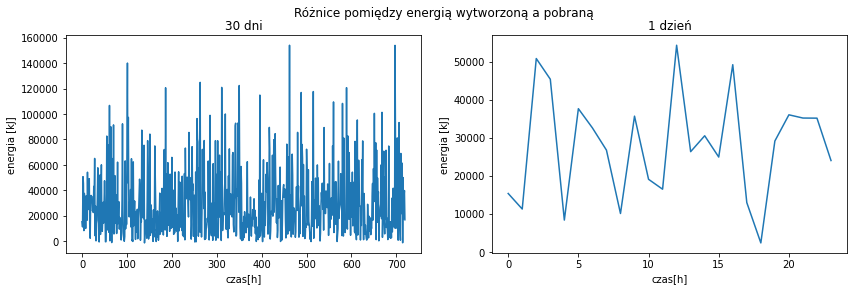

In [37]:
fig, axs = plt.subplots(1,2, figsize=(14,4))
plt.suptitle('Różnice pomiędzy energią wytworzoną a pobraną')
axs[0].plot(dif_state)
axs[0].set_title('30 dni')
axs[0].set_xlabel('czas[h]')
axs[0].set_ylabel('energia [kJ]')

axs[1].plot(dif_state[:24])
axs[1].set_title('1 dzień')
axs[1].set_xlabel('czas[h]')
axs[1].set_ylabel('energia [kJ]')

Można zauważyć, że porcje energi dokładane do akumulatora są bardzo zróżnicowane, od praktycznie zerowych do bardzo dużych. Prawie wcale nie zdarzają się pobory mocy, więc rzadko kiedy musimy używać akumulatora, aby uniknąć braku prądu.

In [38]:
print('Maksymalny pobór mocy z akumulatora:', -min(dif_state), 'kJ')
print('Maksymalny wpływ mocy do akumulatora:', max(dif_state), 'kJ')

Maksymalny pobór mocy z akumulatora: 1297.170621031666 kJ
Maksymalny wpływ mocy do akumulatora: 154071.46607494 kJ


In [39]:
print('Średnia ilość niewykorzystanej energi, wyprodukowanej w ciągu godziny:',np.mean( dif_state), 'kJ')

Średnia ilość niewykorzystanej energi, wyprodukowanej w ciągu godziny: 29998.632455368144 kJ


In [40]:
print('Ilość zgromadzonej energi (niewykorzystanej) w ciągu miesiąca:', ac_state[-1], 'kJ')

Ilość zgromadzonej energi (niewykorzystanej) w ciągu miesiąca: 21599015.367865052 kJ


Zatem podsumowując jeden wiatrak dla trzyosobowej rodziny wystarczy aż nadto. Z kolei akumulator powiniem mieć pojemność równą conajmniej maksymalnemu poborowi mocy, czyli ok. $1500[kJ].$